# GRAPE on a qubit with an uncertain frequency

Lets start with the example of GRAPE on a qubit, optimizing the drive envelope to be robust to variations in qubit frequency. This example will illustrate the utility of batching, allowing us to average over many different qubit frequencies to obtain a pulse that achieves a high-fidelity gate and is robust to frequency fluctuations.

This example is available as a Jupyter notebook [here](https://github.com/dkweiss31/qontrol/blob/main/docs/examples/qubit.ipynb).

In [1]:
from functools import partial

import dynamiqs as dq
import jax
import jax.numpy as jnp
import numpy as np
import optax
from jax import Array
from jax.random import normal, PRNGKey
from matplotlib.pyplot import Axes

import qontrol as ql

In [2]:
time = 30
control_dt = 2.0
ntimes = int(time // control_dt) + 1
optimizer = optax.adam(learning_rate=0.001, b1=0.99, b2=0.99)
tsave = jnp.linspace(0, time, ntimes)
opt_options = {'verbose': False, 'epochs': 4000, 'plot': True, 'plot_period': 200}
dq_options = dq.Options(save_states=False, progress_meter=None)

Here we initialize the random qubit frequency fluctuations pulled from a normal distribution. Note that the drive is on resonance with the average value of the qubit frequency.

In [3]:
key = PRNGKey(42)
n_batch = 21
random_freqs = 2.0 * jnp.pi * normal(key, shape=(n_batch,)) / 500
H0 = random_freqs[:, None, None] * dq.sigmaz()
H1s = [dq.sigmax(), dq.sigmay()]
H1_labels = ['X', 'Y']

Here we define what final states the initial states should map to. In this case we want to achieve a Y gate

In [4]:
initial_states = [dq.basis(2, 0), dq.basis(2, 1)]
target_states = [-1j * dq.basis(2, 1), 1j * dq.basis(2, 0)]

We next initialize our first guess for the controls and define the function that, given the controls, returns the Hamiltonian.

In [5]:
init_drive_params = -0.001 * jnp.ones((len(H1s), ntimes - 1))


def H_pwc(values: Array) -> dq.TimeQArray:
    H = dq.constant(H0)
    for idx, _H1 in enumerate(H1s):
        H += dq.pwc(tsave, values[idx], _H1)
    return H


exp_ops = [dq.basis(2, 1) @ dq.dag(dq.basis(2, 1))]
sesolve_model = ql.sesolve_model(H_pwc, initial_states, tsave, exp_ops=exp_ops)

In this example we use the coherent definition of the infidelity and penalize drive strengths above 16 MHz

In [6]:
costs = ql.coherent_infidelity(target_states=target_states, target_cost=0.001)
costs += ql.control_norm(2.0 * jnp.pi * 0.016, target_cost=0.1)

We modify the default plotter to track both the ground and first excited states individually

In [7]:
def plot_states(
    ax: Axes,
    expects: Array | None,
    model: ql.Model,
    parameters: Array | dict,
    which: int = 0,
) -> Axes:
    ax.set_facecolor('none')
    _tsave = model.tsave_function(parameters)
    for batch_idx in range(n_batch):
        ax.plot(_tsave, np.real(expects[batch_idx, which, 0]))
    ax.set_xlabel('time [ns]')
    ax.set_ylabel(f'population in $|1\\rangle$ for initial state $|{which}\\rangle$')
    return ax


def plot_controls(
    ax: Axes, _expects: Array | None, model: ql.Model, parameters: Array | dict
) -> Axes:
    ax.set_facecolor('none')
    _tsave = model.tsave_function(parameters)
    finer_tsave = jnp.linspace(0.0, _tsave[-1], 10 * len(_tsave))
    for idx, control in enumerate(parameters):
        H_c = dq.pwc(_tsave, control, H1s[idx])
        ax.plot(
            finer_tsave,
            np.real(jax.vmap(H_c.prefactor)(finer_tsave)) / 2 / np.pi,
            label=H1_labels[idx],
        )
    ax.legend(loc='lower right', framealpha=0.0)
    ax.set_ylabel('pulse amplitude [GHz]')
    ax.set_xlabel('time [ns]')
    return ax


plotter = ql.custom_plotter(
    [plot_controls, partial(plot_states, which=0), partial(plot_states, which=1)]
)

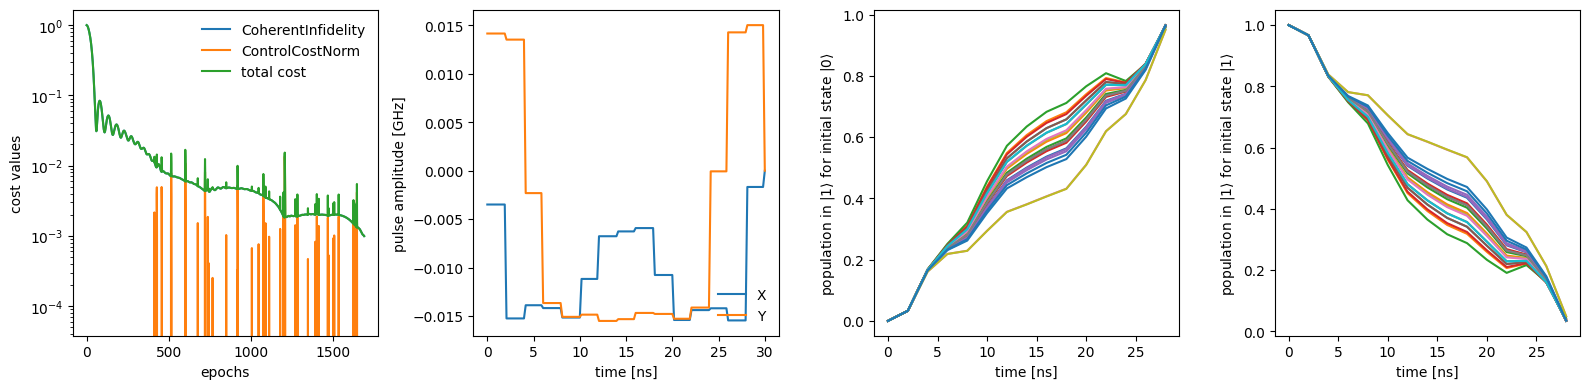

target cost reached for all cost functions;
optimization terminated after 1688 epochs; 
average epoch time (excluding jit) of 0.00103 s; 
max epoch time of 0.01 s; 
min epoch time of 0.001 s


In [8]:
opt_params = ql.optimize(
    init_drive_params,
    costs,
    sesolve_model,
    plotter=plotter,
    optimizer=optimizer,
    opt_options=opt_options,
    dq_options=dq_options,
)

We see that despite the MHz-level frequency variations of the qubit frequency, the obtained pulse succesfully performs the desired state transfer! Here we plot the population in the $|1\rangle$ state when beginning in the $|0\rangle$ state for the different batch instances